In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pdb import set_trace

In [3]:
with_pdb = False

# Helper function

In [4]:
def plot_tensor(tensor):
    new_tensor = np.array(tensor.tolist()).flatten()
    plt.plot(new_tensor)

# Basic Attention Module

In [5]:
class Attention(nn.Module):
    
    def __init__(self, dropout=0.1):
        super(Attention, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if with_pdb:
            set_trace()
        d_k = query.size(-1)
        # first multiplication
        query_x_keys = torch.matmul(query, key.transpose(-2, -1))
        # normalization
        query_x_keys = query_x_keys/math.sqrt(d_k)
        if mask is not None:
            query_x_keys = query_x_keys.masked_fill(mask==0, -1e9)
        # softmax in the last dimension
        attention = F.softmax(query_x_keys, dim = -1)
        # dropout
        attention = self.dropout(attention)
        # attendtion x values
        scores = torch.matmul(attention, value)
        return scores, attention

In [6]:
# q = torch.rand(1, 10, 20)
# k = torch.rand(1, 10, 20)
# v = torch.rand(1, 10, 30)

# attn = Attention(0.1)
# score, attention = attn(q, k, v)

# score.shape

# Multihead attention

In [7]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, d_model, d_k, d_v, n_heads, dropout=0.1):
        
        assert d_model % n_heads == 0
        
        super(MultiheadAttention, self).__init__()
        
        self.h = n_heads
        self.d_k = d_k
        self.d_v = d_v
        
        self.W_q = nn.ModuleList([nn.Linear(in_features=d_model, out_features=d_k) for _ in range(n_heads)])
        self.W_k = nn.ModuleList([nn.Linear(in_features=d_model, out_features=d_k) for _ in range(n_heads)])
        self.W_v = nn.ModuleList([nn.Linear(in_features=d_model, out_features=d_v) for _ in range(n_heads)])
        self.W_o = nn.Linear(in_features=n_heads*d_v, out_features=d_model)
        self.attention_layers = nn.ModuleList([Attention(dropout=dropout) for _ in range(n_heads)])
        
        self.concat_attn = None
        
    def forward(self, query, key, value, mask=None):
        if with_pdb:
            set_trace()
        
        output = []
        attentions = []
        
        for idx_head in range(self.h):
            linear_proj_q = self.W_q[idx_head]
            linear_proj_k = self.W_k[idx_head]
            linear_proj_v = self.W_v[idx_head]
            
            query_h = linear_proj_q(query)
            key_h   = linear_proj_k(key)
            value_h = linear_proj_v(value)
            
            attention_layer = self.attention_layers[idx_head]
            
            out, attn = attention_layer(query_h, key_h, value_h, mask=mask)
            
            output.append(out)
            attentions.append(attn)


            
        concat_out  = torch.cat(output, dim=-1)
        concat_out = self.W_o(concat_out)
        
        concat_attn = torch.cat(attentions, dim=0)
        
        self.concat_attn = concat_attn

        return concat_out, concat_attn
        

In [8]:
# q = torch.rand(1, 10, 40)
# k = torch.rand(1, 10, 40)
# v = torch.rand(1, 10, 40)

# multihead_attn = MultiheadAttention(n_heads=8, d_model=40, d_k=20, d_v=30, dropout=0.1)
# output, attention = multihead_attn(q, k, v)

# output.shape, attention.shape

# FeedForward

In [9]:
class FeedForward(nn.Module):
    
    def __init__(self, d_in, d_ff, d_out, dropout = 0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(in_features=d_in, out_features=d_ff)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=d_ff, out_features=d_out)

        
    def forward(self, x):
        if with_pdb:
            set_trace()
        return self.linear_2(self.relu(self.linear_1(x)))

In [10]:
# x = torch.rand(1, 10, 20)

# ff = FeedForward(d_in = 20, d_ff = 100, d_out = 30)

# new_x = ff(x)

# new_x.shape

# Add Norm

In [11]:
class AddNorm(nn.Module):
    
    def __init__(self, features, eps=1e-6, dropout=0.1):
        super(AddNorm, self).__init__()
        self.a = nn.Parameter(torch.ones(features))
        self.b = nn.Parameter(torch.zeros(features))
        self.features = features
        self.eps = eps
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, layer):
        if with_pdb:
            set_trace()
        if x.shape[-1] != 1:
            add = x + layer(x)
            mean = add.mean(-1, keepdim=True)
            std = add.std(-1, keepdim=True)
            norm = self.a * (add - mean) / (std + self.eps) + self.b
        else:
            norm = x + layer(x)
        
        return self.dropout(norm)

In [12]:
# x = torch.rand(1, 10, 20)

# layer = lambda tensor: tensor + 100

# addnorm = AddNorm(features=20, eps=1e-6, dropout=0.1)

# addnorm(x, layer).shape

torch.Size([1, 10, 20])

# Encoder Layer

In [13]:
class EncoderLayer(nn.Module):
    
    def __init__(self, d_v, d_k, d_ff, d_model, n_heads, dropout):
        super(EncoderLayer, self).__init__()
        self.multihead_attention = MultiheadAttention(d_k=d_k, d_v=d_v, d_model=d_model, dropout=dropout, n_heads=n_heads)
        self.feed_forward = FeedForward(d_in=d_model, d_ff = d_ff, d_out=d_model)
        self.add_norm_1 = AddNorm(features=d_model, dropout=dropout)
        self.add_norm_2 = AddNorm(features=d_model, dropout=dropout)
        
    def forward(self, x):
        if with_pdb:
            set_trace()
        x = self.add_norm_1(x, lambda t: self.multihead_attention(t,t,t)[0])
        x = self.add_norm_2(x, self.feed_forward)
        return x

In [14]:
# x = torch.rand(1, 10, 20)

# encoder_layer = EncoderLayer(d_v=10, d_k=40, d_ff = 100, d_model=20, dropout=0.1, n_heads=2)

# encoder_layer(x).shape

# Encoder

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, d_v, d_k, d_ff, d_model, n_heads, n_layers, dropout):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(
            [EncoderLayer(d_v=d_v, d_k=d_k, d_ff = d_ff, d_model=d_model, dropout=dropout, n_heads=n_heads) for _ in range(n_layers)]
        )
        
    def forward(self, x):
        if with_pdb:
            set_trace()
        for encoder_layer in self.layers:
            x = encoder_layer(x)
        return x

In [16]:
# x = torch.rand(1, 10, 20)

# encoder = Encoder(d_v=10, d_k=40, d_ff=100, d_model=20, dropout=0.1, n_heads=2, n_layers=6)

# encoder(x).shape

# Make mask

In [17]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [18]:
# subsequent_mask(10)

# Decoder Layer

In [19]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_v, d_k, d_ff, d_model, n_heads, dropout):
        super(DecoderLayer, self).__init__()
        self.masked_multihead_attention = MultiheadAttention(d_k=d_k, d_v=d_v, d_model=d_model, dropout=dropout, n_heads=n_heads)
        self.add_norm_1 = AddNorm(features=d_model, dropout=dropout)
        self.multihead_attention = MultiheadAttention(d_k=d_k, d_v=d_v, d_model=d_model, dropout=dropout, n_heads=n_heads)
        self.add_norm_2 = AddNorm(features=d_model, dropout=dropout)
        self.feed_forward = FeedForward(d_in=d_model, d_ff=d_ff, d_out=d_model)
        self.add_norm_3 = AddNorm(features=d_model, dropout=dropout)
        
    def forward(self, x, encoded_memory):
        if with_pdb:
            set_trace()
        mask = subsequent_mask(size = x.size(1))
        x = self.add_norm_1(x, lambda t: self.masked_multihead_attention(t,t,t, mask=mask)[0])
        x = self.add_norm_2(x, lambda t: self.multihead_attention(t, encoded_memory, encoded_memory)[0])
        x = self.add_norm_3(x, self.feed_forward)
        return x

In [20]:
# x = torch.rand(1, 5, 20)
# y = torch.rand(1, 5, 20)

# encoder = Encoder(d_v=10, d_k=40, d_ff=100, d_model=20, dropout=0.1, n_heads=2, n_layers=6)
# memory = encoder(x)

# decoder_layer = DecoderLayer(d_v = 30, d_k = 20, d_ff=100, d_model = 20, n_heads = 4, dropout=0.1)
# decoder_layer(y, memory)

# Decoder

In [21]:
class Decoder(nn.Module):
    
    def __init__(self, d_v, d_k, d_ff, d_model, n_heads, n_layers, dropout):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(
            [DecoderLayer(d_v=d_v, d_k=d_k, d_ff = d_ff, d_model=d_model, dropout=dropout, n_heads=n_heads) for _ in range(n_layers)]
        )
        self.linear_1 = nn.Linear(in_features=d_model, out_features=d_ff)
        self.relu     = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=d_ff, out_features=d_model)
        
    def forward(self, x, memory):
        if with_pdb:
            set_trace()
        for decoder_layer in self.layers:
            x = decoder_layer(x, memory)
        x = self.linear_2(self.relu(self.linear_1(x)))
        return x

In [22]:
# x = torch.rand(1, 5, 20)
# y = torch.rand(1, 5, 20)

# encoder = Encoder(d_v=10, d_k=40, d_ff=100, d_model=20, dropout=0.1, n_heads=2, n_layers=6)
# memory = encoder(x)

# decoder = Decoder(d_v=10, d_k=40, d_ff=100, d_model=20, dropout=0.1, n_heads=2, n_layers=6)
# decoder(x, memory)

# Encoder Decoder

In [23]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target):
        if with_pdb:
            set_trace()

        memory  = self.encoder(source)
        decoded = self.decoder(target, memory)
        return decoded
    

# Test 1 - Signal Denoiser

### Make Model

In [ ]:
encoder = Encoder(d_v=10, d_k=10, d_ff=100, d_model=1, dropout=0.0, n_heads=1, n_layers=2)
decoder = Decoder(d_v=10, d_k=10, d_ff=100, d_model=1, dropout=0.0, n_heads=1, n_layers=2)

encoder_decoder = EncoderDecoder(encoder=encoder, decoder=decoder)

### Optimizer

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(params=encoder_decoder.parameters(), lr=1e-4)

### Test signal - Noisy Sin

In [ ]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq) * np.cos(2 * np.pi * (X/4) / signal_freq) 

# Adding uniform noise
def noisy(Y, noise_range=(-1.75, 1.75)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = np.random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

source, target = sample(1000)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(source, label="signal")
plt.plot(target, linewidth=5, label="signal + noise")
plt.legend()

In [ ]:
# Converts np arrays to tensors
source = torch.tensor(source).reshape(1, len(source), 1).float()
target = torch.tensor(target).reshape(1, len(target), 1).float()

### Training

In [ ]:
# loss_list = []
for epoch in range(3000):  # loop over the dataset multiple times

    running_loss = 0.0
    
    # get the inputs; data is a list of [inputs, labels]

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = encoder_decoder(source = source, target = target)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss = loss.item()
    
    loss_list.append(running_loss)

    if epoch % 50 == 0:
        print(epoch, running_loss)

In [ ]:
plt.plot(loss_list)

In [ ]:
outputs = encoder_decoder(source = source, target = target)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.array(source.tolist()).flatten(), label="source", linewidth=0.3)
plt.plot(np.array(target.tolist()).flatten(), label="target")
plt.plot(np.array(outputs.tolist()).flatten(), label="outputs")
plt.legend()

In [ ]:
attention_0 = encoder_decoder.decoder.layers[0].multihead_attention.concat_attn.detach().numpy()[0]
attention_1 = encoder_decoder.decoder.layers[1].multihead_attention.concat_attn.detach().numpy()[0]

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(attention_0[:30, :30])

In [ ]:
sns.heatmap(attention_1[:30, :30])

# Test 2 - Air Passengers

### Load data

In [ ]:
import pandas as pd

In [ ]:
df_data = pd.read_csv("../resources/AirPassengers.csv")
x_min = df_data["#Passengers"].min()
x_max = df_data["#Passengers"].max()
df_data["#Passengers"] = df_data["#Passengers"].apply(lambda x: (x - x_min)/(x_max - x_min))

In [ ]:
df_data.plot(figsize=(20, 10))

In [ ]:
data_array = df_data["#Passengers"].tolist()
n_obs = len(data_array)
x = []
y = []
for idx in range(n_obs - 10 - 1): 
    new_x = data_array[idx    : 10 + idx]
    new_y = data_array[idx + 1: 10 + idx + 1]
    x.append(new_x)
    y.append(new_y)
x_arr = np.array([np.array(i) for i in x])
y_arr = np.array([np.array(i) for i in y])

x_arr = x_arr.reshape(x_arr.shape[0], x_arr.shape[1], 1)
y_arr = y_arr.reshape(y_arr.shape[0], x_arr.shape[1], 1)

x_arr_train = x_arr[:120]
x_arr_test = x_arr[120:]
y_arr_train = y_arr[:120]
y_arr_test=    y_arr[120:]

source_train = torch.tensor(x_arr_train).float()
target_train = torch.tensor(y_arr_train).float()
source_test = torch.tensor(x_arr_test).float()
target_test = torch.tensor(y_arr_test).float()

### Make model

In [ ]:
encoder = Encoder(d_v=40, d_k=40, d_ff=200, d_model=1, dropout=0.0, n_heads=1, n_layers=1)
decoder = Decoder(d_v=40, d_k=40, d_ff=200, d_model=1, dropout=0.0, n_heads=1, n_layers=1)

encoder_decoder = EncoderDecoder(encoder=encoder, decoder=decoder)

### Optimizer

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(params=encoder_decoder.parameters(), lr=1e-2)

In [ ]:
source_train.shape

### Training

In [ ]:
loss_list = []
for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    
    # get the inputs; data is a list of [inputs, labels]

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs_train = encoder_decoder(source = source_train, target = target_train)
    loss = criterion(outputs_train, target_train)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss = loss.item()
    
    loss_list.append(running_loss)

    if epoch % 50 == 0:
        print(epoch, running_loss)

In [ ]:
plt.plot(loss_list)

In [ ]:
outputs_train = encoder_decoder(source = source_train, target = target_train)

In [ ]:
# Just for plotting
p_outputs_train = outputs_train[:, -1, :]
p_target_train = target_train[:, -1, :]

plt.figure(figsize=(20, 10))
# plt.plot(np.array(source.tolist()).flatten(), label="source", linewidth=0.3)
plt.plot(np.array(p_target_train.tolist()).flatten(), label="target")
plt.plot(np.array(p_outputs_train.tolist()).flatten(), label="outputs")
plt.legend()

In [ ]:
outputs_test = encoder_decoder(source = source_test, target = target_test)

In [ ]:
# Just for plotting
p_outputs_test = outputs_test[:, -1, :]
p_target_test  = target_test[:, -1, :]

plt.figure(figsize=(20, 10))
# plt.plot(np.array(source.tolist()).flatten(), label="source", linewidth=0.3)
plt.plot([i for i in range(p_target_train.shape[0])],
         np.array(p_target_train.tolist()).flatten(), label="train")
plt.plot([i + p_target_train.shape[0] for i in range(p_target_test.shape[0])],
         np.array(p_target_test.tolist()).flatten(), label="target")
plt.plot([i + p_target_train.shape[0] for i in range(p_target_test.shape[0])],
         np.array(p_outputs_test.tolist()).flatten(), label="outputs")
plt.legend()

In [ ]:
attention_0 = encoder_decoder.decoder.layers[0].multihead_attention.concat_attn.detach().numpy()[0]

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(attention_0)

# Test 3 - Retail Forecast

In [99]:
import pandas as pd

In [228]:
df_train = pd.read_csv("../resources/demand-forecasting/train.csv")

In [229]:
df_train["date"] = pd.to_datetime(df_train["date"])
df_train = df_train.set_index("date").groupby(["store", "item"]).resample("W").agg({"sales": "sum"})
df_train = df_train.unstack(level=(0, 1))
df_train.columns = df_train.columns.droplevel(0)
df_train = df_train.apply(lambda x: (x - min(x))/(max(x) - min(x)) )
data_arr = df_train.values

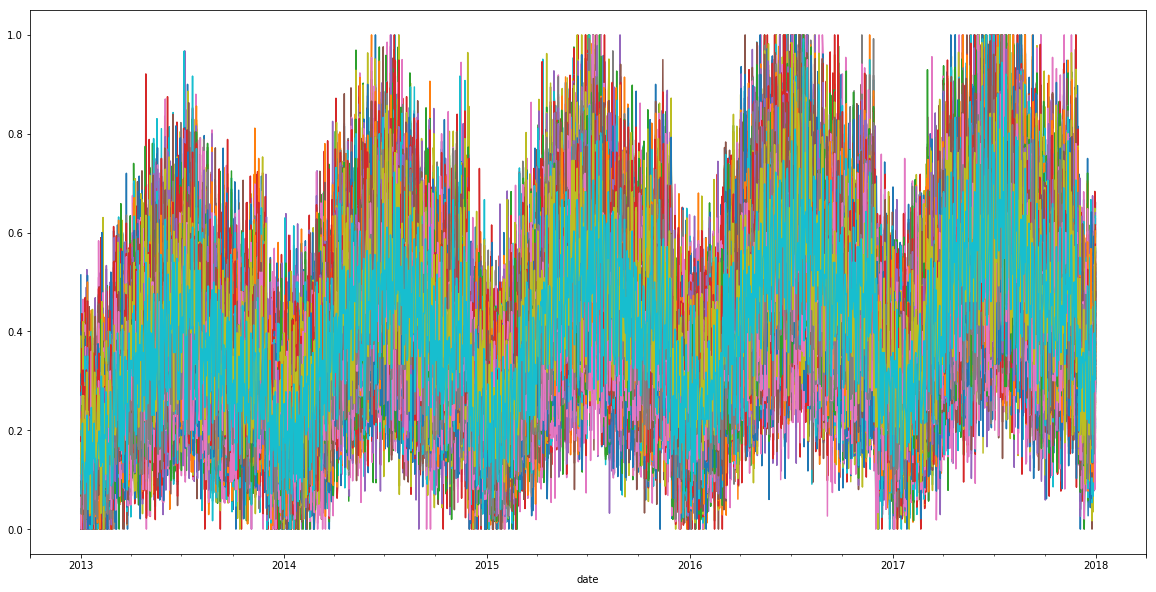

In [178]:
df_train.plot(figsize=(20, 10), legend=False)

In [230]:
data_arr = data_arr.reshape(1, data_arr.shape[0], data_arr.shape[1])

In [231]:
data_arr.shape

(1, 261, 500)

In [131]:
# # generate dataset
# store = 1
# data_arr = df_train.loc[:, store].values
# x = []
# y = []
# lookback = 90
# for idx in range(data_arr.shape[0] - lookback - 1):
#     new_x = data_arr[idx:idx + lookback, :]
#     new_y = data_arr[idx + 1:idx + lookback + 1, :]
#     x.append(new_x)
#     y.append(new_y)
# x = np.array(x)
# y = np.array(y)

In [234]:
train = data_arr[:, :200, :]
test  = data_arr[:,  200:, :]

x_train = train[:,  :199, :]
y_train = train[:, 1:200, :]

x_test = test[:,   :-1, :]
y_test = test[:,  1:, :]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1, 199, 500), (1, 199, 500), (1, 60, 500), (1, 60, 500))

In [235]:
source_train = torch.tensor(x_train).float()
target_train = torch.tensor(y_train).float()
source_test = torch.tensor(x_test).float()
target_test = torch.tensor(y_test).float()

In [249]:
encoder = Encoder(d_v=500, d_k=500, d_ff=5000, d_model=500, dropout=0.0, n_heads=2, n_layers=2)
decoder = Decoder(d_v=500, d_k=500, d_ff=5000, d_model=500, dropout=0.0, n_heads=2, n_layers=2)

encoder_decoder = EncoderDecoder(encoder=encoder, decoder=decoder)

In [251]:
criterion = nn.MSELoss()
optimizer = optim.SGD(params=encoder_decoder.parameters(), lr=1e-1)

In [252]:
loss_list = []
for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    
    # get the inputs; data is a list of [inputs, labels]

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs_train = encoder_decoder(source = source_train, target = target_train)
    loss = criterion(outputs_train, target_train)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss = loss.item()
    
    loss_list.append(running_loss)

    if epoch % 1 == 0:
        print(epoch, running_loss)

0 0.29483139514923096
1 0.13055330514907837
2 0.07746411859989166
3 0.05590055510401726
4 0.04732063040137291
5 0.043916866183280945
6 0.04246965050697327
7 0.04174000769853592
8 0.041275784373283386
9 0.040913745760917664
10 0.04059581086039543
11 0.0403013601899147
12 0.04002310335636139
13 0.03975784778594971
14 0.03950288146734238
15 0.03925791382789612
16 0.039022281765937805
17 0.038795001804828644
18 0.038575179874897
19 0.038362957537174225
20 0.038156453520059586
21 0.03795600309967995
22 0.03776117414236069
23 0.037571799010038376
24 0.037386976182460785
25 0.03720656409859657
26 0.03703037276864052
27 0.03685738891363144
28 0.036687903106212616
29 0.036522019654512405
30 0.03635906055569649
31 0.03619828820228577
32 0.036039989441633224
33 0.03588413447141647
34 0.03573013097047806
35 0.03557766601443291
36 0.03542693704366684
37 0.03527763858437538
38 0.03512955456972122
39 0.03498224914073944
40 0.03483567014336586
41 0.034689899533987045
42 0.03454471006989479
43 0.034399

339 0.02154039777815342
340 0.021799568086862564
341 0.02139870449900627
342 0.02165648527443409
343 0.021274201571941376
344 0.02154194749891758
345 0.021169280633330345
346 0.02143961563706398
347 0.02107713557779789
348 0.02134423516690731
349 0.020986897870898247
350 0.021246135234832764
351 0.02087850496172905
352 0.021124521270394325
353 0.02075151540338993
354 0.020984409376978874
355 0.020608576014637947
356 0.020831463858485222
357 0.02045825682580471
358 0.020676743239164352
359 0.020312663167715073
360 0.020532475784420967
361 0.020176315680146217
362 0.020396770909428596
363 0.020052433013916016
364 0.020270438864827156
365 0.019935596734285355
366 0.02015659771859646
367 0.019823376089334488
368 0.02003864385187626
369 0.019708996638655663
370 0.01991540566086769
371 0.019584154710173607
372 0.019780077040195465
373 0.019443772733211517
374 0.019627336412668228
375 0.019290033727884293
376 0.019464507699012756
377 0.019127793610095978
378 0.019299207255244255
379 0.0189724

669 0.005744504276663065
670 0.0057292720302939415
671 0.005726550705730915
672 0.005711403209716082
673 0.00570853054523468
674 0.005693640094250441
675 0.005691197235137224
676 0.005676864646375179
677 0.005674686748534441
678 0.005660578142851591
679 0.005658457987010479
680 0.005644478369504213
681 0.005642365198582411
682 0.005628535058349371
683 0.005626651458442211
684 0.0056128851138055325
685 0.005610887426882982
686 0.005596932489424944
687 0.005594850052148104
688 0.0055812206119298935
689 0.005579279735684395
690 0.005565662402659655
691 0.005563561804592609
692 0.005550000816583633
693 0.005547686479985714
694 0.00553407846018672
695 0.0055320351384580135
696 0.005518467631191015
697 0.005516634788364172
698 0.005503279622644186
699 0.005501976236701012
700 0.005488680675625801
701 0.0054871696047484875
702 0.00547434575855732
703 0.005472645163536072
704 0.005459731910377741
705 0.005458654370158911
706 0.00544568570330739
707 0.00544465146958828
708 0.00543184345588088
7

997 0.0043242210522294044
998 0.00431952066719532
999 0.004320980980992317


In [253]:
output_train = encoder_decoder(source = source_train, target = target_train)

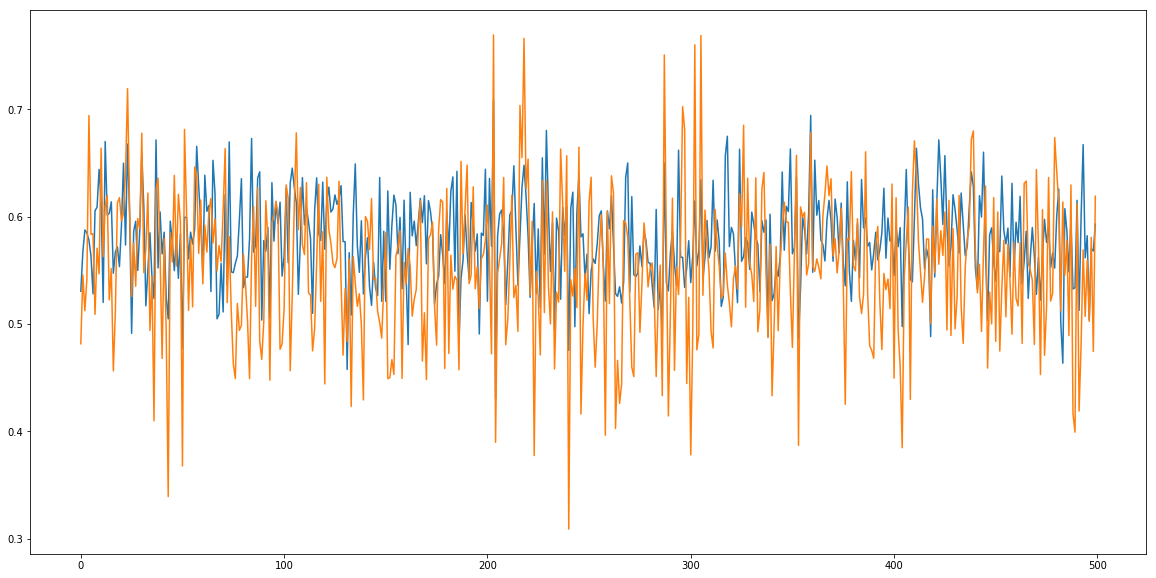

In [254]:
plt.figure(figsize=(20, 10))
plot_tensor(output_train[0, -1, :])
plot_tensor(target_train[0, -1, :])

In [255]:
output_test = encoder_decoder(source = source_test, target = target_test)

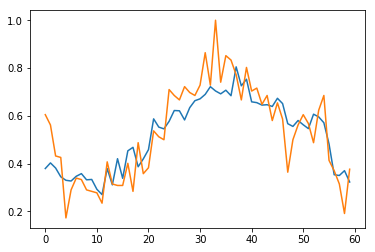

In [257]:
plot_tensor(output_test[0, :, 0])
plot_tensor(target_test[0, :, 0])

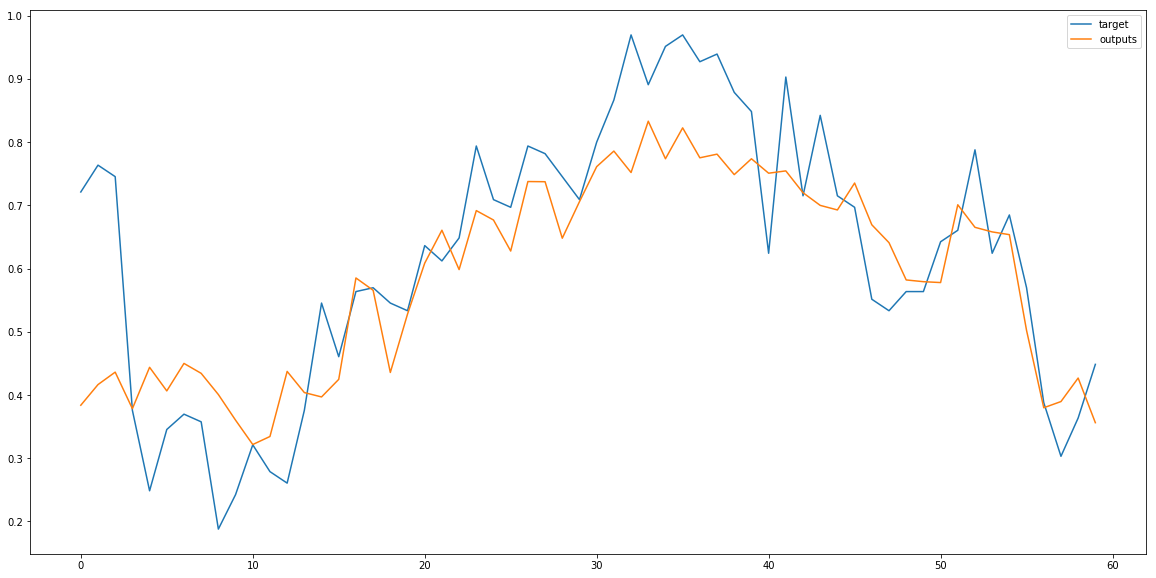

In [260]:
# Just for plotting
p_outputs_test = output_test[:, :, 15]
p_target_test  = target_test[:, :, 15]

plt.figure(figsize=(20, 10))
# plt.plot(np.array(source.tolist()).flatten(), label="source", linewidth=0.3)
plt.plot(np.array(p_target_test.tolist()).flatten(), label="target")
plt.plot(np.array(p_outputs_test.tolist()).flatten(), label="outputs")
plt.legend()

In [208]:
attention_0 = encoder_decoder.decoder.layers[0].multihead_attention.concat_attn.detach().numpy()[0]
# attention_1 = encoder_decoder.decoder.layers[1].multihead_attention.concat_attn.detach().numpy()[0]

In [209]:
import seaborn as sns

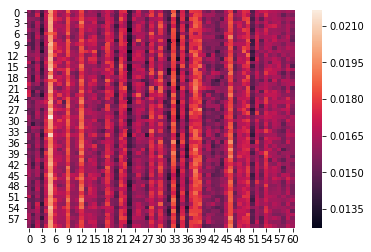

In [210]:
sns.heatmap(attention_0)